In [1]:
import numpy as np
import pandas as pd

# Parâmetros da série mensal para 5 anos
np.random.seed(555)
periods = 60  # 5 anos de dados mensais

# Índice de datas mensais (início de mês)
dates = pd.date_range(start='2020-01-01', periods=periods, freq='MS')

# Componentes da série
trend = np.linspace(19, 16, periods)  # tendência linear
seasonal = 5 * np.sin(2 * np.pi * dates.month / 12)  # sazonalidade anual mensal
noise = np.random.normal(scale=1, size=periods)    # ruído

# Combinação dos componentes
y = trend + seasonal + noise

# Criação do DataFrame
df = pd.DataFrame({'y': y}, index=dates)

In [2]:
df.head()

,y
2020-01-01,21.648227
2020-02-01,23.632766
2020-03-01,22.811055
2020-04-01,23.424681
2020-05-01,21.139770


<AxesSubplot: >

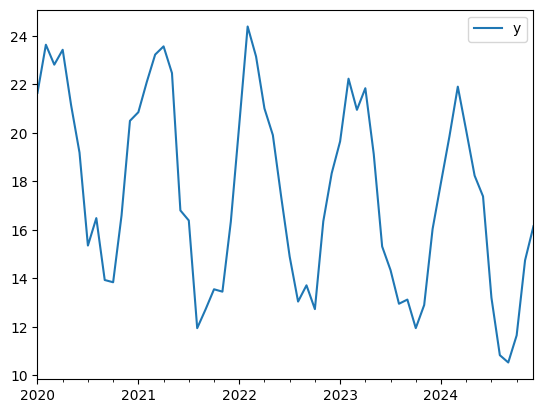

In [3]:
df.plot()

## 1 - Engenharia de Feature

In [4]:
import numpy as np
import pandas as pd

# Faz uma cópia para manter o df original intacto
df_feat = df.copy()

# 1. Lags: traz valores antigos de y para dar histórico ao modelo
lags = [1, 2, 3, 6, 12]
for lag in lags:
    # Cria colunas lag_1, lag_2, etc., com y deslocado no tempo
    df_feat[f'lag_{lag}'] = df_feat['y'].shift(lag)
    # Exemplo: lag_1 é y de um mês atrás; lag_12, de 12 meses atrás

# 2. Estatísticas móveis: resumem comportamento recente de y
windows = [3, 6, 12]
for w in windows:
    # Média dos últimos w meses (sem olhar o mês atual)
    df_feat[f'rolling_mean_{w}'] = (
        df_feat['y']
        .shift(1)                   # não vaza o valor de y no mês t
        .rolling(window=w)          # janela de tamanho w
        .mean()                     # calcula a média
    )
    # Desvio padrão dos últimos w meses
    df_feat[f'rolling_std_{w}'] = (
        df_feat['y']
        .shift(1)
        .rolling(window=w)
        .std()
    )
    # Valor mínimo nos últimos w meses
    df_feat[f'rolling_min_{w}'] = (
        df_feat['y']
        .shift(1)
        .rolling(window=w)
        .min()
    )
    # Valor máximo nos últimos w meses
    df_feat[f'rolling_max_{w}'] = (
        df_feat['y']
        .shift(1)
        .rolling(window=w)
        .max()
    )

# 3. Diferença e momentum: medidas de variação de um mês para o outro
# Diferença absoluta
df_feat['diff_1'] = df_feat['y'] - df_feat['y'].shift(1)
# Razão (crescimento percentual aproximado)
df_feat['momentum_1'] = df_feat['y'] / df_feat['y'].shift(1)

# 4. Dados de calendário: capturam padrões sazonais
df_feat['month']   = df_feat.index.month   # mês (1–12)
df_feat['quarter'] = df_feat.index.quarter # trimestre (1–4)
df_feat['year']    = df_feat.index.year    # ano (e.g., 2020)

# Codificação cíclica para mês (evita corte brusco entre Dez/Jan)
df_feat['month_sin'] = np.sin(2 * np.pi * df_feat['month'] / 12)
df_feat['month_cos'] = np.cos(2 * np.pi * df_feat['month'] / 12)

# 5. Quantis móveis: adiciona estatísticas de posição
for q in [0.25, 0.5, 0.75]:
    # Ex.: rolling_q25_6 é o 25º percentil dos últimos 6 meses
    df_feat[f'rolling_q{int(q*100)}_6'] = (
        df_feat['y']
        .shift(1)
        .rolling(window=6)
        .quantile(q)
    )

# 6. Flag de mudanças bruscas: marca picos ou quedas grandes
# Se a variação mensal ultrapassa 2× o desvio padrão, marca 1
df_feat['jump_flag'] = (
    df_feat['diff_1'].abs() > df_feat['diff_1'].std() * 2
).astype(int)

# 7. Tendência local: estimativa de inclinação em janelas curtas
from scipy.stats import linregress

def rolling_slope(x):
    # Retorna a inclinação da reta ajustada em cada janela
    idx = np.arange(len(x))
    return linregress(idx, x).slope

# Exemplo de janelas de 3, 4, 6, 8 e 12 pontos
for window, name in [(3,'3'), (3,'4'), (3,'6'), (3,'8'), (3,'12')]:
    df_feat[f'trend_{name}'] = (
        df_feat['y']
        .shift(1)
        .rolling(window=window)
        .apply(rolling_slope, raw=True)
    )

# 8. Termos não-lineares: polinômios e interações
# Quadrado do lag_1, captura curvaturas
df_feat['lag1_sq'] = df_feat['lag_1'] ** 2

# 9. Limpeza final: apaga linhas que ficaram com NaN após shifts/rollings
df_feat = df_feat.dropna()

# Visualiza as primeiras linhas com as novas features
df_feat.head()

,y,lag_1,lag_2,lag_3,lag_6,lag_12,rolling_mean_3,rolling_std_3,rolling_min_3,rolling_max_3,...,rolling_q25_6,rolling_q50_6,rolling_q75_6,jump_flag,trend_3,trend_4,trend_6,trend_8,trend_12,lag1_sq
2021-01-01,20.849808,20.494034,16.587912,13.834370,15.348694,21.648227,16.972106,3.346414,13.834370,20.494034,...,14.282800,15.914590,16.561056,0,3.329832,3.329832,3.329832,3.329832,3.329832,420.005445
2021-02-01,22.092289,20.849808,20.494034,16.587912,16.480486,23.632766,19.310585,2.364604,16.587912,20.849808,...,14.565748,16.534199,19.517504,0,2.130948,2.130948,2.130948,2.130948,2.130948,434.714509
2021-03-01,23.227200,22.092289,20.849808,20.494034,13.927502,22.811055,21.145377,0.839122,20.494034,22.092289,...,14.592605,18.540973,20.760865,0,0.799127,0.799127,0.799127,0.799127,0.799127,488.069244
2021-04-01,23.565193,23.227200,22.092289,20.849808,13.834370,23.424681,22.056432,1.189101,20.849808,23.227200,...,17.564443,20.671921,21.781669,0,1.188696,1.188696,1.188696,1.188696,1.188696,539.502798
2021-05-01,22.461485,23.565193,23.227200,22.092289,16.587912,21.139770,22.961561,0.771547,22.092289,23.565193,...,20.582978,21.471049,22.943472,0,0.736452,0.736452,0.736452,0.736452,0.736452,555.318337


## 2 - Divisao temporal da base

In [5]:
train_size = int(len(df) * 0.65)
X = df_feat.drop('y', axis=1)
y = df_feat['y']


X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
n_samples = X_train.shape[0]

In [6]:
X_train

,lag_1,lag_2,lag_3,lag_6,lag_12,rolling_mean_3,rolling_std_3,rolling_min_3,rolling_max_3,rolling_mean_6,...,rolling_q25_6,rolling_q50_6,rolling_q75_6,jump_flag,trend_3,trend_4,trend_6,trend_8,trend_12,lag1_sq
2021-01-01,20.494034,16.587912,13.834370,15.348694,21.648227,16.972106,3.346414,13.834370,20.494034,16.112166,...,14.282800,15.914590,16.561056,0,3.329832,3.329832,3.329832,3.329832,3.329832,420.005445
2021-02-01,20.849808,20.494034,16.587912,16.480486,23.632766,19.310585,2.364604,16.587912,20.849808,17.029019,...,14.565748,16.534199,19.517504,0,2.130948,2.130948,2.130948,2.130948,2.130948,434.714509
2021-03-01,22.092289,20.849808,20.494034,13.927502,22.811055,21.145377,0.839122,20.494034,22.092289,17.964319,...,14.592605,18.540973,20.760865,0,0.799127,0.799127,0.799127,0.799127,0.799127,488.069244
2021-04-01,23.227200,22.092289,20.849808,13.834370,23.424681,22.056432,1.189101,20.849808,23.227200,19.514269,...,17.564443,20.671921,21.781669,0,1.188696,1.188696,1.188696,1.188696,1.188696,539.502798
2021-05-01,23.565193,23.227200,22.092289,16.587912,21.139770,22.961561,0.771547,22.092289,23.565193,21.136073,...,20.582978,21.471049,22.943472,0,0.736452,0.736452,0.736452,0.736452,0.736452,555.318337
2021-06-01,22.461485,23.565193,23.227200,20.494034,19.182849,23.084626,0.565498,22.461485,23.565193,22.115002,...,21.160429,22.276887,23.035771,1,-0.382857,-0.382857,-0.382857,-0.382857,-0.382857,504.518323
2021-07-01,16.797719,22.461485,23.565193,20.849808,15.348694,20.941466,3.630774,16.797719,23.565193,21.498949,...,21.160429,22.276887,23.035771,0,-3.383737,-3.383737,-3.383737,-3.383737,-3.383737,282.163358
2021-08-01,16.383057,16.797719,22.461485,22.092289,16.480486,18.547420,3.396015,16.383057,22.461485,20.754490,...,18.121361,22.276887,23.035771,0,-3.039214,-3.039214,-3.039214,-3.039214,-3.039214,268.404546
2021-09-01,11.940863,16.383057,16.797719,23.227200,13.927502,15.040546,2.692399,11.940863,16.797719,19.062586,...,16.486722,19.629602,23.035771,0,-2.428428,-2.428428,-2.428428,-2.428428,-2.428428,142.584203
2021-10-01,12.718347,11.940863,16.383057,23.565193,13.834370,13.680755,2.372329,11.940863,16.383057,17.311111,...,13.634524,16.590388,21.045544,0,-1.832355,-1.832355,-1.832355,-1.832355,-1.832355,161.756344


## 3 - Tunando os hiperparametros com walk-forward

In [7]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

# 1) Função geradora de splits para walk‑forward
def walk_forward_splits(n_samples, initial_train=24, horizon=3, step=1):
    """
    Gera tuplas (train_idx, test_idx) para um esquema:
    - treino inicial: [0, initial_train)
    - previsão: [initial_train, initial_train + horizon)
    - depois: treino ↑ 1 mês, e assim por diante, até caber horizon.
    """
    start = initial_train
    while start + horizon <= n_samples:
        train_idx = np.arange(start)                 # do 0 até start-1
        test_idx  = np.arange(start, start + horizon)  # próximos horizon pontos
        yield train_idx, test_idx
        start += step

In [8]:
# 2) Estimador e o espaço de busca
model = XGBRegressor(objective='reg:squarederror', random_state=42)

param_dist = {
    'n_estimators': [50, 100, 200,400,500,1000],
    'max_depth':    [3, 5, 7,10,15],
    'learning_rate':[0.01, 0.05, 0.1,0.3,0.5],
    'subsample':    [0.2,0.4,0.6, 0.8, 1.0],
    'colsample_bytree':[0.2,0.4,0.6, 0.8, 1.0],
    'reg_alpha': [0,0.01,0.05,0.1,0.5],
    'reg_lambda': [0,0.01,0.05,0.1,0.5]
}

In [9]:
# 4) Configurando o RandomizedSearchCV com nosso CV customizado
cv_splits = list(walk_forward_splits(n_samples,
                                     initial_train=24,
                                     horizon=3,
                                     step=1))

search = RandomizedSearchCV(
    estimator     = model,
    param_distributions=param_dist,
    n_iter        = 200,
    scoring       = 'neg_mean_squared_error',
    cv            = cv_splits,
    verbose       = 1,
    random_state  = 42,
    n_jobs        = -1
)

In [10]:
# 5) Rode a busca
search.fit(X_train, y_train)

# 6) Resultados
print("Melhores parâmetros:", search.best_params_)
print("Melhor score (neg MSE):", search.best_score_)

Fitting 13 folds for each of 200 candidates, totalling 2600 fits
Melhores parâmetros: {'subsample': 0.4, 'reg_lambda': 0, 'reg_alpha': 0.1, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
Melhor score (neg MSE): -0.7437365712522118


## 4 - Verificando os resultados finais

In [11]:
from sklearn.metrics import mean_squared_error

train_end = train_size

# 1) Gerando previsões separadas
pred_train = search.predict(X_train)
pred_test  = search.predict(X_test)

# 2) Convertendo para Series conforme os indices
pred_train_series = pd.Series(pred_train, index=df_feat.index[:train_end])
pred_test_series  = pd.Series(pred_test,  index=df_feat.index[train_end:])

# 3) Calculo do RMSE
rmse_train = mean_squared_error(y_train, pred_train, squared=False)
rmse_test  = mean_squared_error(y_test,  pred_test,  squared=False)

print(f'RMSE Treino: {rmse_train:.4f}')
print(f'RMSE Teste:  {rmse_test:.4f}')

RMSE Treino: 0.3044
RMSE Teste:  1.4698


C:\Users\gcabr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\gcabr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


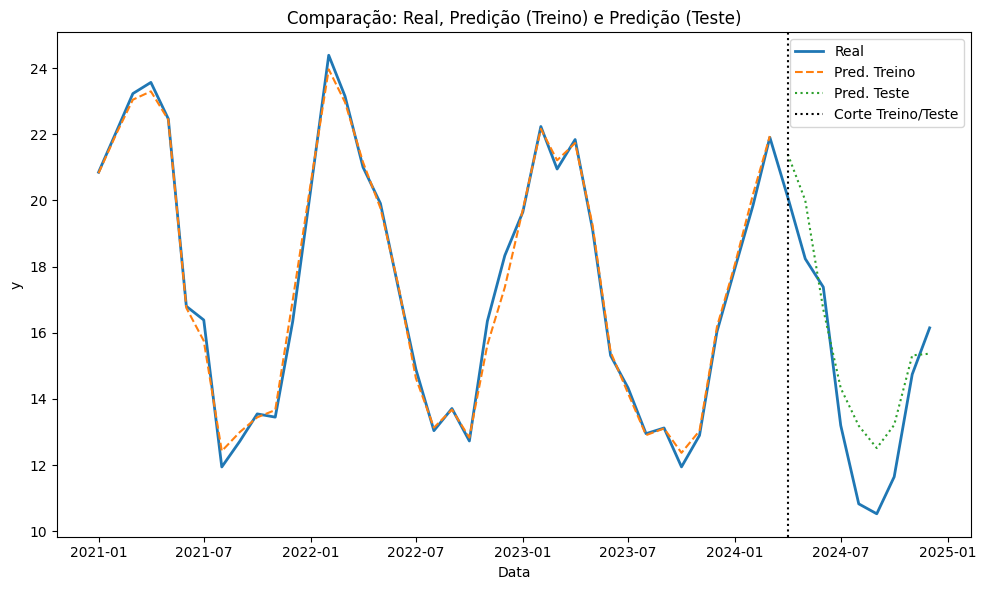

In [12]:
import matplotlib.pyplot as plt

# 4) Plotando: Real vs Previsto com linha de corte
plt.figure(figsize=(10, 6))
plt.plot(df_feat.index, y,              label='Real',       linewidth=2)
plt.plot(pred_train_series.index, pred_train_series, label='Pred. Treino', linestyle='--')
plt.plot(pred_test_series.index,  pred_test_series,  label='Pred. Teste',  linestyle=':')
plt.axvline(df_feat.index[train_end], color='k', linestyle=':', label='Corte Treino/Teste')
plt.xlabel('Data')
plt.ylabel('y')
plt.title('Comparação: Real, Predição (Treino) e Predição (Teste)')
plt.legend()
plt.tight_layout()
plt.show()